In [6]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda,UpSampling2D, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization, Activation
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam,RMSprop
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
import sys
import os
import numpy as np
import math
import random, time
from pathlib                        import Path
from PIL                            import Image

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt 
import gc
import glob
from skimage                        import img_as_ubyte
from skimage                        import io
import shutil
tf.keras.backend.clear_session()

2025-05-20 23:05:50.072124: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 23:05:50.189632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-20 23:05:50.253648: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-20 23:05:50.278980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 23:05:50.361502: I tensorflow/core/platform/cpu_feature_guar

### <font color="red">1. Processing data</font>


#### <font color="red">1.1. Selecting a Sample</font>

In [8]:
#general_path_data = '/home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5'
general_path_data ='/home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI'

subdirectories = ['/Geometry','/Magnitude','/Pression','/U001','/U002']

geo_path =  general_path_data + subdirectories[0]
v_path   =  general_path_data + subdirectories[1]
p_path   =  general_path_data + subdirectories[2]
vx_path  =  general_path_data + subdirectories[3]
vy_path  =  general_path_data + subdirectories[4]

In [9]:
#method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)

def resizing_img(x,new_width=200):
   
    height=x.shape[0]
    width=x.shape[1]
    ratio = height / width
    new_height = int(new_width * ratio)
    y =cv.resize(x,(new_width,new_height))
    return y

# method for turning to a grey or binary image 
def processing(image,option):
        x = get_img(image)  
        x = rgb2gray(x)               # It returns a grayscale image with floating point values in the range from 0 to 1
        y = resizing_img(x) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            y=ski.util.img_as_ubyte(y)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(y)) #  Otsu’s method calculates an “optimal” threshold

            _,y= cv.threshold(y, best_value_threshold, 255, cv.THRESH_BINARY)
            y=y/255.
        y=y[:, :, np.newaxis]
        return y

def create_file(path,name='Images_masked'):
     newpath = path +'/' +name
     os.makedirs(newpath, exist_ok=True)
     return newpath

In [10]:
def create_npy(path_origin,name_sub_file,option,n_sample = 1000):
    images = sorted([os.path.join(path_origin,fname) for fname in os.listdir(path_origin) if fname.endswith(".png")])
    current_path = os.getcwd() 
    if (n_sample <= 20000):

        I = images[1:n_sample+1]
        newpath1=create_file(current_path)
        new_root = newpath1 +'/' +name_sub_file
        os.makedirs(new_root, exist_ok=True)
   
        for img in I:
            name_img = os.path.splitext(os.path.basename(img))[0]
            save_in=new_root+'/'+ name_img+'.npy'
            print(save_in)
            x=processing(img,option)
            np.save(save_in,x)  

In [20]:
def mask(path1,path2,save_in,new_npy):
    path_1 = Path(path1)
    file_npy_1=sorted(list(path_1.glob('*.npy')))
    
    path_2 = Path(path2)
    file_npy_2=sorted(list(path_2.glob('*.npy')))
    n=1
    for f1, f2 in zip(file_npy_1,file_npy_2):
            new_save_in=save_in+ '/'+new_npy+f'_{n:05d}.npy'
            array_1 = np.load(f1)
            array_2 = np.load(f2)
            array_masked=array_1*array_2
            np.save(new_save_in,array_masked)
            print('*********',new_save_in)
            n+=1
           
    

In [ ]:
def create_file_masked(file1,file2,name_npy,name):
    path1 =  os.getcwd() 
    path2= create_file(path1,name)
    print(path2)
    mask(file1,file2,path2,name_npy)

def split_data(file,n_train,n_valid,n_test):
     n_sample=len(file)
     if (round(n_train + n_valid + n_test,2) == 1.0):
        n_train= math.floor(n_sample*n_train)
        n_valid = math.floor(n_sample*n_valid) + n_train
        n_test = math.floor(n_sample*n_test) + n_valid
        (train,valid,test) = (file[0:n_train], file[n_train:n_valid],file[n_valid:n_test]) 
     return train,valid,test  

# separating images into different folders
def create_files(name_file): 
    
   # name_file = geo_masked mag_masked  vx_masked vy_masked p_masked
   # path = /home/ppgi/Trabajo/Codigos_generate_data/DLCODES-VER-5/mag_masked
    
    path=general_directory + name_file
    file = Path(path)
    
    images= sorted(file.glob('*.png')) 
    train,valid,test =  split_data(images)
    
    path_train = general_directory +name_file+ '/train'
    path_test = general_directory + name_file+'/test'
    path_valid = general_directory +name_file+ '/valid'
    print('creating')
    os.makedirs(path_train, exist_ok=True)
    os.makedirs(path_test, exist_ok=True)
    os.makedirs(path_valid, exist_ok=True)
    
    for img in train:
        p =  path_train + '/' + img.name
        shutil.move(img,p)
    
    for img in valid:  
        p = path_valid + '/' + img.name
        shutil.move(img,p)

    for img in test: 
        p = path_test + '/' + img.name
        shutil.move(img,p)    
    

In [9]:
create_npy(geo_path,'geo',True,n_sample = 5)

/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo/geo_00001.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo/geo_00002.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo/geo_00003.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo/geo_00004.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo/geo_00005.npy


In [10]:
create_npy(p_path ,'P',False,n_sample = 5)

/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P/p_00001.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P/p_00002.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P/p_00003.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P/p_00004.npy
/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P/p_00005.npy


In [13]:
file1='/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/geo'
file2='/home/guiomar/Desktop/CODES/predicting-flow-patterns/Images_masked/P'

In [22]:
create_file_masked(file1,file2,'p')

/home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask
********* /home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00001.npy
********* /home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00002.npy
********* /home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00003.npy
********* /home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00004.npy
********* /home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00005.npy


In [34]:
x = np.load('/home/guiomar/Desktop/CODES/predicting-flow-patterns/Final_mask/p_00004.npy')

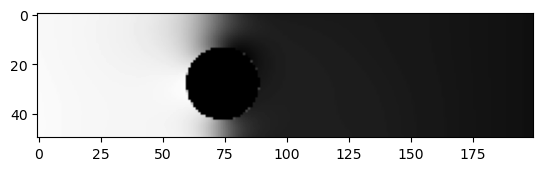

In [35]:
plt.imshow(x,cmap='gray')

In [ ]:
def create_files(name,general_file_name, create_one_file=None):
    list_files_arrays = ['Geometry','Magnitude','Pression','Vx','Vy']
    current_path = os.getcwd()
    file_finded = [name for name in os.listdir( current_path) if os.path.isdir(os.path.join( current_path, name))]
    if create_one_file != None:
       name_path = name_file[0] + '/' + name


file = [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]
name_file=[name for name in file if name == general_file_name]
name_path = name_file[0] + '/' + name
f = Path(name_path)
arrays= sorted(file.glob('*.npy'))
train,valid,test =  split_data(arrays)
    
     
   
    
    path_train = general_directory +name_file+ '/train'
    path_test = general_directory + name_file+'/test'
    path_valid = general_directory +name_file+ '/valid'
    print('creating')
    os.makedirs(path_train, exist_ok=True)
    os.makedirs(path_test, exist_ok=True)
    os.makedirs(path_valid, exist_ok=True)
    
    for img in train:
        p =  path_train + '/' + img.name
        shutil.move(img,p)
    
    for img in valid:  
        p = path_valid + '/' + img.name
        shutil.move(img,p)

    for img in test: 
        p = path_test + '/' + img.name
        shutil.move(img,p)    